<a href="https://colab.research.google.com/github/tanyakuznetsova/Word-Embeddings-on-Brown-Corpus/blob/main/Word_Embeddings_on_Brown_Corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Word embeddings on Brown corpus

Natural Language Processing tasks are getting increasingly important and are their various applications are predicted to continue to expand; however, the sheer volume of English language words (or any other language, for that matter) presents a challenge for language-based applications.

One helpful approach is to use a clustering, or embedding of the vocabulary you're working with so that words similar in meaning are clustered together, that is, have embeddings close to each other.

Famously, John Firth put it best in 1957:

*You shall know a words by the company it keeps*

In this short project, I will showcase this idea and come yo with word embeddings based on co-occurence statistics.



In [ ]:
import numpy as np
import pickle
import nltk
import string
from collections import defaultdict
from nltk.corpus import brown, stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt

I will work with a relatively compact Brown corpus, which can be conveniently downloaded from the natural language toolkit library ```nltk```. This is a collection of text samples from a wide range of sources, with a total of over a million words.

In [ ]:
nltk.download('brown')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
brown.words()[:50]

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of',
 "Atlanta's",
 'recent',
 'primary',
 'election',
 'produced',
 '``',
 'no',
 'evidence',
 "''",
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 '.',
 'The',
 'jury',
 'further',
 'said',
 'in',
 'term-end',
 'presentments',
 'that',
 'the',
 'City',
 'Executive',
 'Committee',
 ',',
 'which',
 'had',
 'over-all',
 'charge',
 'of',
 'the',
 'election',
 ',',
 '``',
 'deserves',
 'the',
 'praise']

Working with this corpus is made easier with the standard NLP preprocessing, during which I remove stopwords and punctuation as well as make all words lowercase.
Additionally, I remove single letter words and those strings that consist of numbers only:

In [ ]:
punctuation = list(string.punctuation)
punctuation

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [1]:
my_stopwords = stopwords.words('english') + punctuation
word_stream = [str(w).lower() for w in brown.words() if w.lower() not in my_stopwords]
# numbers and single letter words removed
my_word_stream = [w for w in word_stream if (len(w) > 1 and w.isalnum())]

NameError: name 'stopwords' is not defined

In [ ]:
len(my_stopwords)

211

In [ ]:
my_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
len(my_word_stream)

513240

In [ ]:
my_word_stream[:20]

['fulton',
 'county',
 'grand',
 'jury',
 'said',
 'friday',
 'investigation',
 'recent',
 'primary',
 'election',
 'produced',
 'evidence',
 'irregularities',
 'took',
 'place',
 'jury',
 'said',
 'presentments',
 'city',
 'executive']

The next block creates a dictionary with a count of occurence for each word:

In [ ]:
word_count = defaultdict(int)
for w in my_word_stream:
        word_count[w] += 1

In [ ]:
counts = sorted([(word_count[w], w) for w in word_count], reverse = True)

In [ ]:
len(brown.words())

1161192

In [ ]:
len(counts)

40853

Vocabulary words $V$ are the most popular words that occur the most (based on the sorting done above for the variable ```counts```).
Context words $C$ are a smaller subsection of the top 1000 most commonly occurring words.

In [ ]:
V = [x[1] for x in counts[:5000]] #larger vocab
C = [x[1] for x in counts[:1000]] #smaller context vocab

For each word in the larger vocanulary $w \in V$ , and each occurrence of it in the text stream, there is a surrounding window of four words, two before and two after:

$$w1 \text{ }w2 \text{ }w \text{ }w3 \text{ }w4$$

Keeping count of how often context words from the smaller context vocabulary appear in this context window around a word $w$ and storing these counts in a dictionary ```counts``` will then allow for the probability distribution $P(c|w)$ of context words around $w$, and the overall distribution $P(c)$ for context words:



In [ ]:
N = len(my_word_stream)

def get_counts(window_size=2):
    counts = {}
    for w0 in V:
        counts[w0] = {}
    for i in range(window_size, N-window_size):
        w0 = my_word_stream[i]
        if w0 in V:
            for j in (list(range(-window_size,0)) + list(range(1,window_size+1))):
                w = my_word_stream[i+j]
                if w in C:
                    if w not in counts[w0].keys():
                        counts[w0][w] = 1
                    else:
                        counts[w0][w] = counts[w0][w] + 1
    return counts

In [ ]:
def get_co_occurrence_dictionary(counts):
    probs = {}
    for w0 in counts.keys():
        sum = 0
        for w in counts[w0].keys():
            sum = sum + counts[w0][w]
        if sum > 0:
            probs[w0] = {}
            for w in counts[w0].keys():
                probs[w0][w] = float(counts[w0][w])/float(sum)
    return probs

In [ ]:
def get_context_word_distribution(counts):
    counts_context = {}
    sum_context = 0
    context_frequency = {}
    for w in C:
        counts_context[w] = 0
    for w0 in counts.keys():
        for w in counts[w0].keys():
            counts_context[w] = counts_context[w] + counts[w0][w]
            sum_context = sum_context + counts[w0][w]
    for w in C:
        context_frequency[w] = float(counts_context[w])/float(sum_context)
    return context_frequency

Each vocabulary word w can be represented by a $|C|$-dimentional vector $\Phi(w)$, whose $c$'th coordinate is $$\Phi_c(w) = \max\begin{pmatrix}0, \log\dfrac{P(c|w}{P(c)}\end{pmatrix}$$

The following block creates this represenation, known as the *pointwise mutual information matrix*, which has been quite successful in word on word embeddings:

In [ ]:
print ("Computing counts and distributions")
counts = get_counts(2)
probs = get_co_occurrence_dictionary(counts)
context_frequency = get_context_word_distribution(counts)
#
print ("Computing pointwise mutual information")
n_vocab = len(V)
n_context = len(C)
pmi = np.zeros((n_vocab, n_context))
for i in range(0, n_vocab):
    w0 = V[i]
    for w in probs[w0].keys():
        j = C.index(w)
        pmi[i,j] = max(0.0, np.log(probs[w0][w]) - np.log(context_frequency[w]))

Computing counts and distributions
Computing pointwise mutual information


In [ ]:
pmi.shape

(5000, 1000)

Quick look at the first entry in the point-mutual information matrix. It should look like a high-dimensional sparse data set:

In [ ]:
pmi[0]

array([0.        , 0.00454069, 0.11485721, 0.        , 0.21263231,
       0.35555824, 0.80153894, 0.23717775, 0.        , 0.0916592 ,
       0.5829183 , 0.        , 0.        , 0.        , 0.        ,
       0.31708831, 0.        , 0.        , 0.        , 0.        ,
       0.58845537, 0.        , 0.        , 0.        , 0.        ,
       0.46765288, 0.3470934 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.07330044, 0.        ,
       0.37030969, 1.16234327, 1.7437545 , 0.21167872, 0.31686112,
       0.21834473, 0.67179916, 0.        , 0.        , 0.71994945,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.38906548, 0.36493508, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.21849914, 0.08174949,
       0.        , 0.66901681, 0.3356647 , 0.        , 0.        ,
       0.        , 0.        , 0.29064102, 0.        , 0.08945

## Dimensionality reduction

To reduce the dimensionality, I am opting for singular Value Decomposition as opposed to the usual Principal Component analysis generally used to decompose data.

I am choosing ```TruncatedSVD``` because:

- ```PCA``` assumes that the input data is going to be in the dense format, not sparse
- ```TruncatedSVD``` is specifically designed for dimensionality reduction of sparse data. Unlike PCA, it does not center the data before computing the singular value
decomposition.
-  ```TruncatedSVD``` takes advantage of the sparcity of data to perform faster matrix factorization and is therefore computationally efficient and requires less memory. The brown corpus is, admittedly, quite small, but this quality of SVD becomes increasingly crucial when working with larger datasets.

In [ ]:
svd = TruncatedSVD(n_components = 100)

svd.fit(pmi)

vecs = svd.fit_transform(pmi)

#normalizing the vectors to unit length
for i in range(0,n_vocab):
    vecs[i] = vecs[i]/np.linalg.norm(vecs[i])

In [ ]:
vecs.shape

(5000, 100)

In [ ]:
vecs[0]

array([ 7.50232634e-01,  1.77802078e-01, -1.16953163e-01,  4.31878045e-02,
        2.14685312e-01, -1.30626666e-01,  1.87443375e-01,  3.69326032e-02,
        9.80752621e-04,  1.19127323e-01, -8.35712121e-02, -1.11674282e-01,
       -1.05963615e-01, -1.13195642e-01,  1.66000896e-01,  2.63666893e-03,
       -3.09580606e-02,  1.09807974e-03, -3.26424858e-02, -8.84871987e-02,
       -1.12437158e-01, -6.84845705e-04,  5.43383422e-03, -3.08992917e-02,
       -9.49619842e-02, -6.02845561e-02,  5.07642478e-02,  2.91585079e-02,
        7.29310395e-02, -5.09458807e-02, -3.10093404e-02,  2.38731513e-02,
        5.01395100e-02, -6.87457986e-02, -3.14758268e-02, -4.33664884e-02,
       -3.46160209e-02, -1.96082333e-02,  1.92825214e-02,  4.47997496e-02,
       -2.15734310e-03, -1.19978373e-02, -5.46325301e-03, -1.67049477e-02,
       -2.08328900e-02, -1.14139616e-02,  3.74306543e-02,  3.63553353e-03,
       -7.98979586e-02,  6.37388256e-02,  8.62298876e-02, -2.25943690e-02,
        2.44884855e-02, -

## Investigating the embeddings

Let's create a random selection of 25 words from the vocabulary V and investigate these embeddings

In [ ]:
import random
random_25 = list(np.random.choice(V, size = 25))
random_25

['valley', 'attract', 'maturity', 'georgia', 'retained', 'junior', 'satisfied', 'freddy', 'muscle', 'emergency', 'documents', 'chapel', 'land', 'belt', 'advised', 'million', 'increases', 'males', 'column', 'material', 'control', 'interest', 'lights', 'structural', 'firms']

In [ ]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors = 2,
                       algorithm = 'auto',
                       metric = 'cosine')

knn.fit(vecs)

NearestNeighbors(metric='cosine', n_neighbors=2)

In [ ]:
for w in random_25:

  #finding the index of the random word in the vocabulary
  target_index = V.index(w)
  target_vec = vecs[target_index].reshape(1, -1) #corresp vector & reshaping
  distances, neigh_indices = knn.kneighbors(target_vec,
                                             n_neighbors = 2,
                                             return_distance = True)

  NN_word = [V[i] for i in neigh_indices.flatten()[1:]]
  #cosmetic changes to remove the list-like appearance
  NN_word = ', '.join(NN_word)
  print(f'{w} --> {NN_word}')

valley --> river
attract --> succession
maturity --> show
georgia --> university
retained --> attempted
junior --> school
satisfied --> decided
freddy --> salem
muscle --> showed
emergency --> complete
documents --> public
chapel --> built
land --> area
belt --> beauty
advised --> officers
million --> billion
increases --> wage
males --> probably
column --> starting
material --> also
control --> system
interest --> also
lights --> dark
structural --> data
firms --> agencies


Some of these nearesr neighbors are more successful than others - e.g. million and billion, firms and agencies, land and area, while others do not seem to have immediate connection. I played around with the different metric (l2 vs cosine), however, the results were not significantly different.

## Clustering the vocabulary

I will use two algorithms for clustering the vocabulary.

First, I will do this with ```KMeans```, a classic choice for creating clusters. It is suitable for a situation when we want to overtly specify the number of clusters. There are other choices to consider for when there is no stipulation to come up with a specific number of clusters (in this case, 100), and we can allow an algorithm the freedom to select the number of clusters based on affinity or density, e.g. DBSCAN or Affinity Propagation).

For the purposes of this project, I chose the classic KMeans as a starting point, with the default lloyd algorithm, and,  therefore, the squared Euclidean distance.

In [ ]:
kmeans = KMeans(n_clusters=100,
                n_init = 'auto')
cluster_assignments = kmeans.fit_predict(vecs)

#a dictionary to store words in each cluster
clusters = {i: [] for i in range(100)}

#populate the clusters dictionary with words
for i, word in enumerate(V):
    clusters[cluster_assignments[i]].append(word)

#print words in each cluster
for cluster_id, words in clusters.items():
    print(f"Cluster {cluster_id + 1}:", words)

Cluster 1: ['two', 'years', 'three', 'several', 'four', 'times', 'five', 'ago', 'six', 'minutes', 'hundred', 'ten', 'nearly', 'couple', 'seven', 'played', 'eight', 'thousand', 'dollars', 'nine', 'twenty', 'fifty', 'thirty', 'fifteen', 'dozen', 'millions', 'twelve', 'pounds', 'acres', 'prison', 'eleven', 'forty', 'nights', 'fewer', 'fourteen', 'ranging', '1956', 'seconds', 'concerts', 'roughly', 'intervals', '300', 'seventeen', 'peas', 'consisted', '70', 'generations', 'sixty']
Cluster 2: ['trying', 'eye', 'whatever', 'write', 'fight', 'giving', 'touch', 'learn', 'impossible', 'buy', 'escape', 'explain', 'dream', 'negroes', 'draw', 'worry', 'unable', 'thoughts', 'soil', 'pull', 'easier', 'leaves', 'blind', 'promised', 'catch', 'throw', 'sell', 'focus', 'discover', 'decide', 'finish', 'anywhere', 'release', 'push', 'waste', 'blame', 'invariably', 'shakespeare', 'happening', 'cure', 'shoot', 'harm', 'stupid', 'barrel', 'spencer', 'lift', 'killing', 'harder', 'mess', 'desperately', 'helple

# Cluster visualization

To visualize the individual clusters, I used ```TSNE```:

In [ ]:
from sklearn.manifold import TSNE

def visualize_TSNE(cluster_num):

  cluster_indices = [V.index(word) for word in clusters[cluster_num]]
  cluster_vecs = vecs[cluster_indices]
  cluster_words = np.array(V)[cluster_indices]

  tsne = TSNE(n_components = 2,
              perplexity = 25).fit_transform(cluster_vecs)

  plt.figure(figsize = (12, 10))

  plt.scatter(tsne[:, 0], tsne[:, 1],
              c = 'black',
              marker = '.',
              #s = 150,
              label = cluster_words)

  for i, txt in enumerate(cluster_words):
    plt.annotate(txt, (tsne[:, 0][i],
                       tsne[: , 1][i]),
                 xytext = (-5, 5),
                 textcoords = ('offset points'))

  plt.grid(True)
  plt.xlabel('feature 1')
  plt.ylabel('feature 2')
  plt.title(f'word embeddings visualization using TSNE for cluster {cluster_num}')
  plt.show()

Cluster 6 using KMeans seems to include words for body parts, descriptive adjectives for appearance and sensations, and clothing:

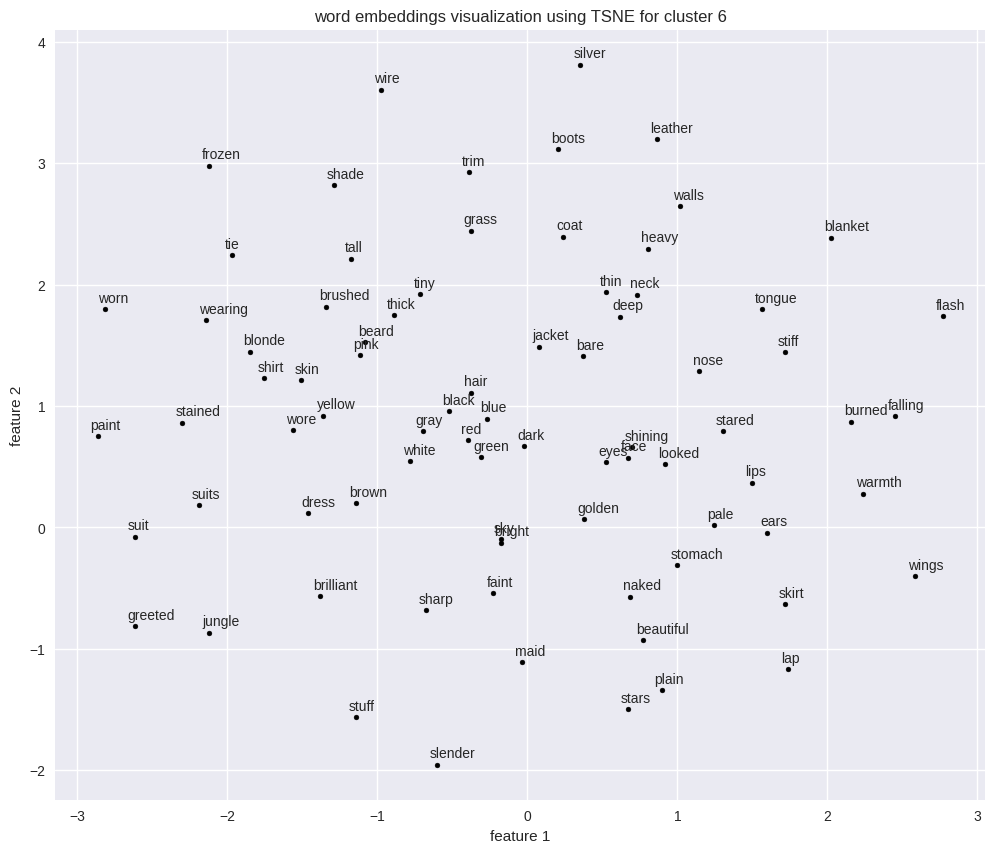

In [ ]:
visualize_TSNE(6)

Cluster 14, KMeans, seems to revolve around philosophy, religion and cognition:

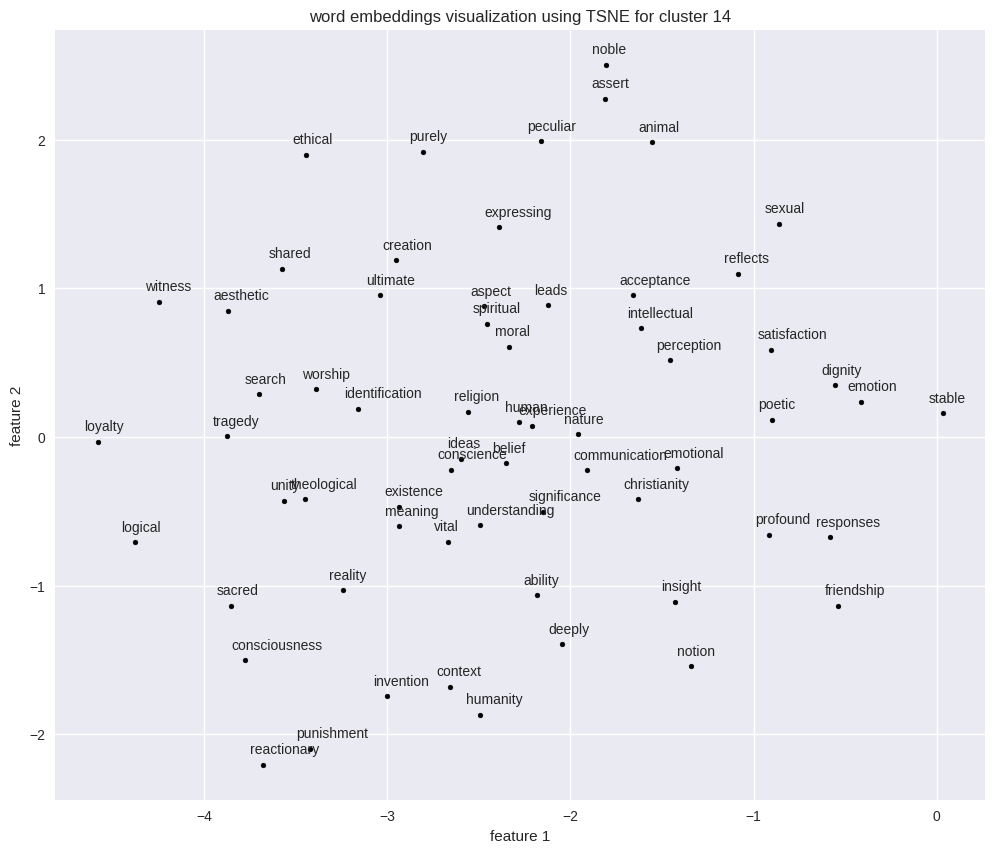

In [ ]:
visualize_TSNE(14)

Cluster 78, Kmeans, also leans heavily into religion, spirituality and worship:

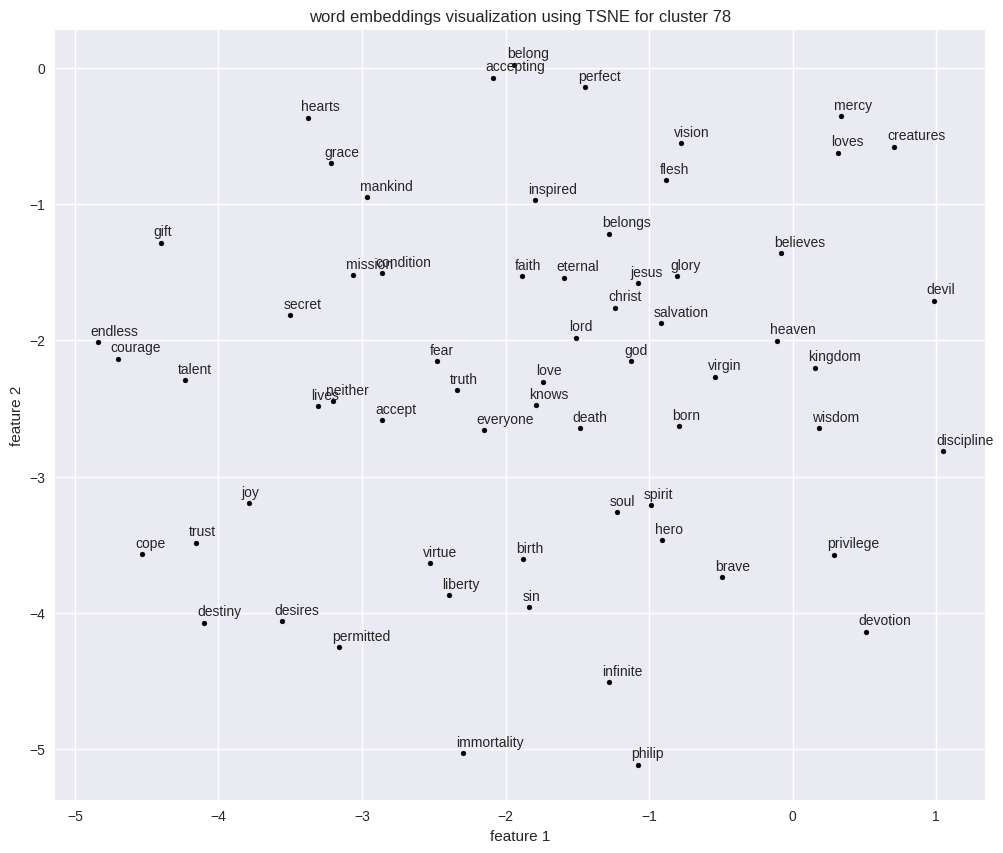

In [ ]:
visualize_TSNE(78)

Other than ```KMeans```, clustering can also be done hierarchically, for example, with ```fcluster``` algorithm from the scipy library. This algorithm also allows for overtly specifying the number of clusters to come up with rather than letting the algorithm decide that number. However, clustering is done agglomeratively, based on the linkage matrix (also using the squared Euclidean function).

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster

Z = linkage(vecs, method = 'ward')

ward_clusters = fcluster(Z, t = 100, criterion = 'maxclust')

In [ ]:
clusters = {i: [] for i in range(1, 101)}

for i, word in enumerate(V):
    cluster_id = ward_clusters[i]
    clusters[cluster_id].append(word)

for cluster_id, words in clusters.items():
    print(f"Cluster {cluster_id}:", words)

Cluster 1: ['equipment', 'production', 'designed', 'machine', 'materials', 'produce', 'shelter', 'potential', 'commercial', 'machinery', 'machines', 'vehicles', 'manufacturers', 'marketing', 'cooling', 'automatic', 'processing', 'handling', 'cotton', 'tools', 'suitable', 'testing', 'plastic', 'mills', 'efficient', 'selling', 'utility', 'sba', 'rigid', 'manufacturer', 'gin', 'rhythm', 'specialists', 'makers', 'ambition', 'milling', 'manufacture']
Cluster 2: ['business', 'company', 'industry', 'market', 'stock', 'industrial', 'plant', 'supply', 'demand', 'oil', 'construction', 'du', 'substantial', 'competition', 'goods', 'motors', 'advertising', 'supplies', 'sold', 'expansion', 'agricultural', 'supplied', 'substantially', 'producing', 'pont', 'owners', 'metropolitan', 'engineers', 'markets', 'decline', 'competitive', 'unions', 'suburban', 'textile', 'manufacturing', 'replacement', 'solely', 'patents', 'mechanics']
Cluster 3: ['money', 'pay', 'sent', 'paid', 'bill', 'placed', 'charge', 'h

Cluster 28 achieved with hierarchical clustering has a theme of academia running through it:

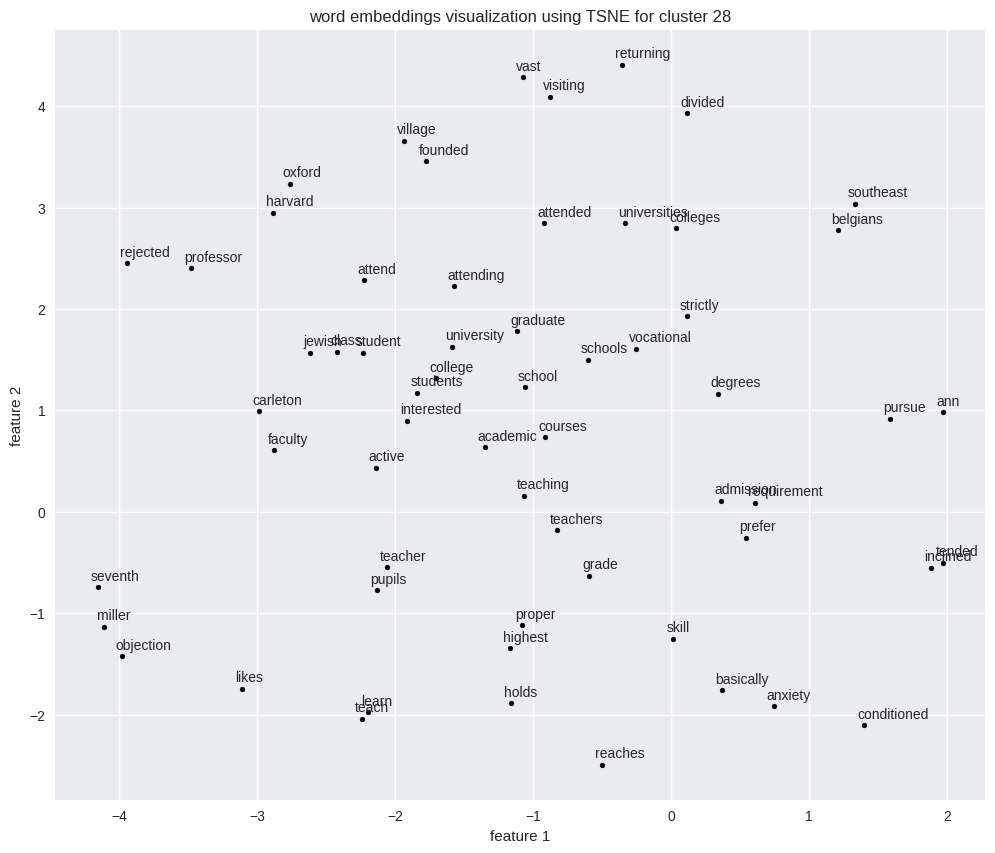

In [ ]:
visualize_TSNE(28)

Hierarchical cluster 55 revolves around performance arts and entertainment:

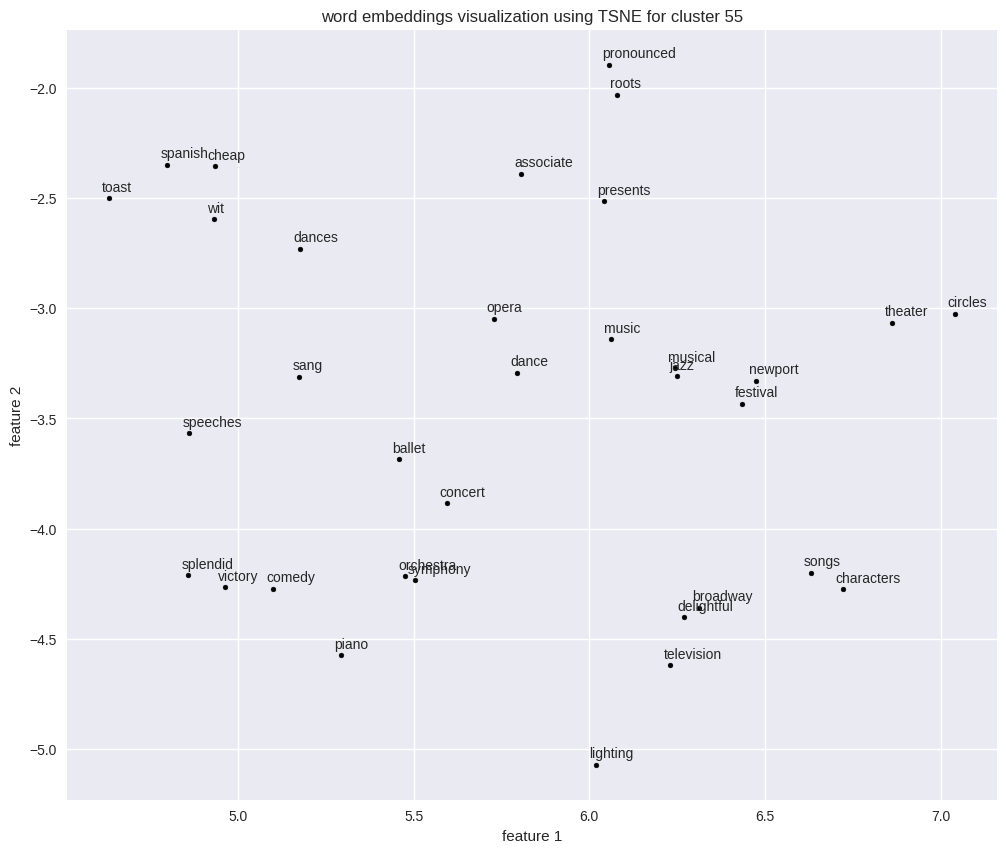

In [ ]:
visualize_TSNE(55)

Hierarchical cluster 68 concerns words with biblical, theological and societal themes:

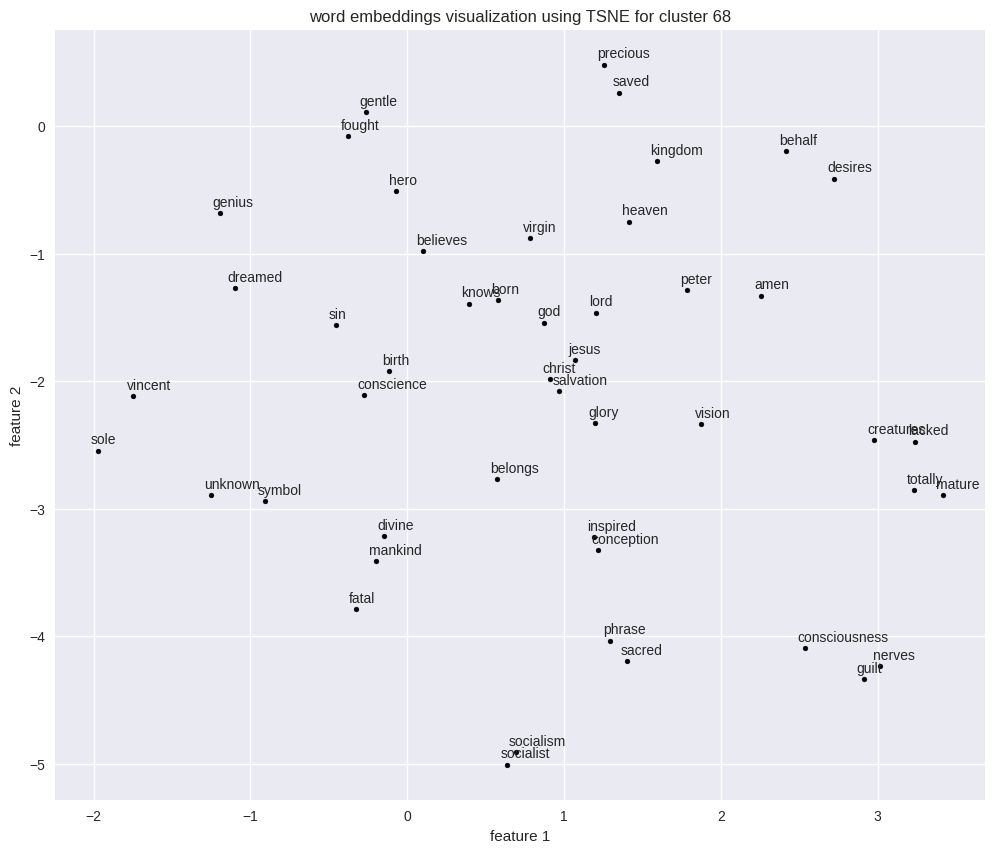

In [ ]:
visualize_TSNE(68)

In [ ]:
!jupyter nbconvert '/content/drive/MyDrive/Colab Notebooks/Word Embeddings on Brown Corpus.ipynb' --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Word Embeddings.ipynb to html
[NbConvertApp] Writing 1497658 bytes to /content/drive/MyDrive/Colab Notebooks/Word Embeddings.html
